In [2]:
import numpy as np 
import pandas as pd 
import os 
import sys 
import plotly.graph_objects as go 
import re

In [3]:
OR_LEARNING_PATH = os.path.join(os.getcwd().split('OR_learning')[0], 'OR_learning/')
sys.path.insert(0, os.path.join(OR_LEARNING_PATH, 'utils/'))

import voxel_functions as vf
import color_function as cf 
import plot_functions as pf 
import BindingCavity_functions as bc 
import SequenceAlignment_functions as sa 

In [216]:
import importlib 

importlib.reload(bc)
importlib.reload(vf)
importlib.reload(pf)
importlib.reload(cf)
importlib.reload(sa)

<module 'SequenceAlignment_functions' from '/mnt/data2/Justice/OR_learning/utils/SequenceAlignment_functions.py'>

## Canonical binding cavity correlation 
This notebook explores the general information captured in Cbc voxels. 
<br>And investigates how does Cbc alone correlates with OR's Grantham distance or odor response. 

### Correlation matrix 

In [4]:
# Read in canonical binding cavity filtered coordinates 
Cbc_cav_coords = pd.read_pickle('/data/jlu/OR_learning/files/binding_cavity/dict_Cbc_cav_coords.pkl')
Cbc_res_coords = pd.read_pickle('/data/jlu/OR_learning/files/binding_cavity/dict_Cbc_res_coords.pkl')
canonical_bc_coords = pd.read_pickle('/data/jlu/OR_learning/files/binding_cavity/canonical_bc_coords.pkl')

# DROP non DL_OR names
Cbc_cav_coords = {key: value for key, value in Cbc_cav_coords.items() if key.startswith('Or')}
Cbc_res_coords = {key: value for key, value in Cbc_res_coords.items() if key.startswith('Or')}

In [ ]:
# DROP Or defined in the exclusion list below
TEST_OR_LIST = ['Or1Ad1', 'Or2T43', 'Or2T48', 'Or10A2',]
TEST_cav_coords = {_olfr: Cbc_cav_coords[_olfr] for _olfr in TEST_OR_LIST if _olfr in Cbc_cav_coords.keys()}
TEST_res_coords = {_olfr: Cbc_res_coords[_olfr] for _olfr in TEST_OR_LIST if _olfr in Cbc_res_coords.keys()}
# Voxelize binding cavity coordinates 
TEST_voxelized_cavities, TEST_voxel_shape = vf.voxelize_cavity(list(TEST_cav_coords.values()), 
                                                               list(TEST_res_coords.values()), resolution=1)
flattened_voxels = [voxel.flatten() for voxel in TEST_voxelized_cavities]

TEST_corr_matrix = np.corrcoef(flattened_voxels)

fig = go.Figure(data=go.Heatmap(
    x = TEST_OR_LIST,
    y = TEST_OR_LIST,  
    z=TEST_corr_matrix, 
    text=np.round(TEST_corr_matrix,3), 
    texttemplate="%{text}",
    textfont={"size":20},
    colorscale='viridis'))
fig.show()
fig.write_html('/data/jlu/OR_learning/output/Canonical_bc/Correlation/TEST_corr_matrix.html')

In [ ]:
"""
Create correlation matrix from flattened voxels 
"""

voxelized_cav_res, voxel_shape = vf.voxelize_cavity(list(Cbc_cav_coords.values()), 
                                                    list(Cbc_res_coords.values()), resolution=1)

# Combine all voxel arrays into a single 4D array (n_samples x X x Y x Z)
voxel_array = np.stack(voxelized_cav_res)  # Shape: (n_samples, X, Y, Z)

# Compute the variance for each spatial position across all samples
voxel_variance = np.var(voxel_array, axis=0)  # Shape: (X, Y, Z)

# Create a mask for positions with non-zero variance
non_zero_variance_mask = voxel_variance > 0  # Shape: (X, Y, Z)

# Apply the mask to filter out zero-variance positions
filtered_voxels = voxel_array[:, non_zero_variance_mask]  # Shape: (n_samples, filtered_positions)

# Flatten the filtered voxel arrays for correlation matrix computation
flattened_voxels = filtered_voxels.reshape(filtered_voxels.shape[0], -1)

# Compute the correlation matrix
corr_matrix = np.corrcoef(flattened_voxels)
corr_df = pd.DataFrame(
    corr_matrix,
    columns=Cbc_cav_coords.keys(),
    index=Cbc_cav_coords.keys()
)
corr_df = corr_df.sort_index()[np.sort(corr_df.columns)] # Sort the index and column 
# corr_df.to_csv('/data/jlu/OR_learning/output/Canonical_bc/Correlation/Cbc_corr_df.csv')

# Quick peak of df
filter_OR = ['Or1A1', 'Or2T43', 'Or2T48', 'Or51E1']
corr_df.loc[(corr_df.index.isin(filter_OR))][filter_OR]

### PCA cavity 
- quick PCA dimensional reduction to visualize distribution via cavity itself 

In [ ]:
from sklearn.decomposition import PCA

voxelized_cav_res, voxel_shape = vf.voxelize_cavity(list(Cbc_cav_coords.values()), 
                                                    list(Cbc_res_coords.values()), resolution=1)

# Example: voxelized_cavities is a list of 3D binary arrays (0s and 1s)
# Flatten the voxelized cavities into a 2D array
flattened_voxelized_cav_res = np.array([voxel.flatten() for voxel in voxelized_cav_res])

# Center the data (subtract the mean of each feature)
mean_centered_data = flattened_voxelized_cav_res - np.mean(flattened_voxelized_cav_res, axis=0)

# Remove features (columns) with no variance (all 0s or all 1s)
non_constant_mask = np.std(mean_centered_data, axis=0) > 0
filtered_data = mean_centered_data[:, non_constant_mask]

# Apply PCA to reduce dimensionality
pca = PCA(n_components=2)  # Reduce to 2 dimensions
reduced_data = pca.fit_transform(filtered_data)
variance_ratio = pca.explained_variance_ratio_

print("Reduced data shape:", reduced_data.shape)
print("Explained variance ratio:", variance_ratio)


pca_df = pd.DataFrame(reduced_data, columns=['PCA_1', 'PCA_2'],
                        index=list(Cbc_cav_coords.keys()))
pca_df = pca_df.sort_index()
pca_df.to_csv('../../output/Canonical_bc/PCA/pca_df.csv')

In [ ]:
# Load in PCA data if needed 
# pca_df = pd.read_csv('../../output/Canonical_bc/PCA/pca_df.csv', index_col=0)

# Visualize pca 
OR_name = list(pca_df.sort_index().index)

# Extract the Or_group using a list comprehension with regex
or_groups = [re.match(r'(Or\d+[A-Za-z])', str(name)).group(0) for name in OR_name if name.startswith('Or')]
or_groups_unique = list(set(or_groups))

# Assigns OR group color
color_map = cf.distinct_colors(or_groups_unique)
# Initialize a set to track displayed legend groups
shown_legend_groups = set()

fig = go.Figure()
for i, data in enumerate(pca_df.sort_index().values):
    if OR_name[i].startswith('Or'): 
        # Extracts the OR group 
        OR_group = re.match(r'(Or\d+[A-Za-z])', str(OR_name[i])).group(0)
        
        # Determine whether to show the legend for this group
        show_legend = OR_group not in shown_legend_groups
        if show_legend:
            shown_legend_groups.add(OR_group)
        fig.add_trace(go.Scatter(x = [data[0]],
                                y = [data[1]],
                                mode = 'markers', 
                                marker=dict(
                                    color = color_map[OR_group]
                                ),
                                name = f'{OR_group} family',
                                hovertext= OR_name[i],
                                legendgroup=OR_group,
                                showlegend=show_legend # Only show legend for the first trace in this group
            ))
    else: 
        fig.add_trace(go.Scatter(x = [data[0]],
                                y = [data[1]],
                                name = OR_name[i], 
                                mode = 'markers'))        
fig.update_traces( marker=dict(size=10, opacity = 0.5))
fig.update_layout(xaxis_title = f'PC1 ({variance_ratio[0]*100:.2f}%)',
                  yaxis_title = f'PC2 ({variance_ratio[1]*100:.2f}%)',
                  margin=dict(r=10, l=10, b=10, t=10),
                  plot_bgcolor='white',  # set the plot background color to white
                  paper_bgcolor='white',  # set the paper background color to white
)
fig.show()
# fig.write_html('../../output/Canonical_bc/PCA/PCA_res1.html')

In [ ]:
# Visualize pca 
OR_name = list(pca_df.sort_index().index)

# Extract the Or_group using a list comprehension with regex
or_groups = [re.match(r'(Or\d+)', str(name)).group(0) for name in OR_name if name.startswith('Or')]
or_groups_unique = list(set(or_groups))

# Assigns OR group color
color_map = cf.distinct_colors(or_groups_unique)
# Initialize a set to track displayed legend groups
shown_legend_groups = set()

fig = go.Figure()
for i, data in enumerate(pca_df.sort_index().values):
    if OR_name[i].startswith('Or'): 
        # Extracts the OR group 
        OR_group = re.match(r'(Or\d+)', str(OR_name[i])).group(0)
        
        # Determine whether to show the legend for this group
        show_legend = OR_group not in shown_legend_groups
        if show_legend:
            shown_legend_groups.add(OR_group)
        fig.add_trace(go.Scatter(x = [data[0]],
                                y = [data[1]],
                                mode = 'markers', 
                                marker=dict(
                                    color = color_map[OR_group]
                                ),
                                name = f'{OR_group} family',
                                hovertext= OR_name[i],
                                legendgroup=OR_group,
                                showlegend=show_legend # Only show legend for the first trace in this group
            ))
    else: 
        fig.add_trace(go.Scatter(x = [data[0]],
                                y = [data[1]],
                                name = OR_name[i], 
                                mode = 'markers'))        
fig.update_traces( marker=dict(size=10, opacity = 0.5))
fig.update_layout(xaxis_title = f'PC1 ({variance_ratio[0]*100:.2f}%)',
                  yaxis_title = f'PC2 ({variance_ratio[1]*100:.2f}%)',
                  margin=dict(r=10, l=10, b=10, t=10),
                  plot_bgcolor='white',  # set the plot background color to white
                  paper_bgcolor='white',  # set the paper background color to white
)
fig.show()
# fig.write_html('../../output/Canonical_bc/PCA/PCA_res1_ORfamily.html')

#### PCA euclidean distance comparison

In [65]:
pca_df = pd.read_csv('../../output/Canonical_bc/PCA/pca_df.csv', index_col=0)
corr_df = pd.read_csv('../../output/Canonical_bc/Correlation/Cbc_corr_df.csv', index_col=0)

In [84]:
from scipy.spatial.distance import pdist, squareform

# Calculate pairwise Euclidean distances
distances = pdist(pca_df.values, metric="euclidean")

# converting distance to z-score 
mean_dist = np.mean(distances)
std_dist = np.std(distances)
z_scores = (distances - mean_dist) / std_dist

# Convert to a squareform distance matrix
PCA_Cbc_df = pd.DataFrame(
    squareform(z_scores), 
    index=pca_df.index, 
    columns=pca_df.index
)

# Extract the upper triangular part of the matrix (excluding the diagonal)
# triu_indices = np.triu_indices_from(PCA_Cbc_df, k=1)
# pairwise_distances = pd.DataFrame({
#     "OR1": PCA_Cbc_df.index[triu_indices[0]],
#     "OR2": PCA_Cbc_df.columns[triu_indices[1]],
#     "Distance": distances, 
#     "z-score": z_scores
# })

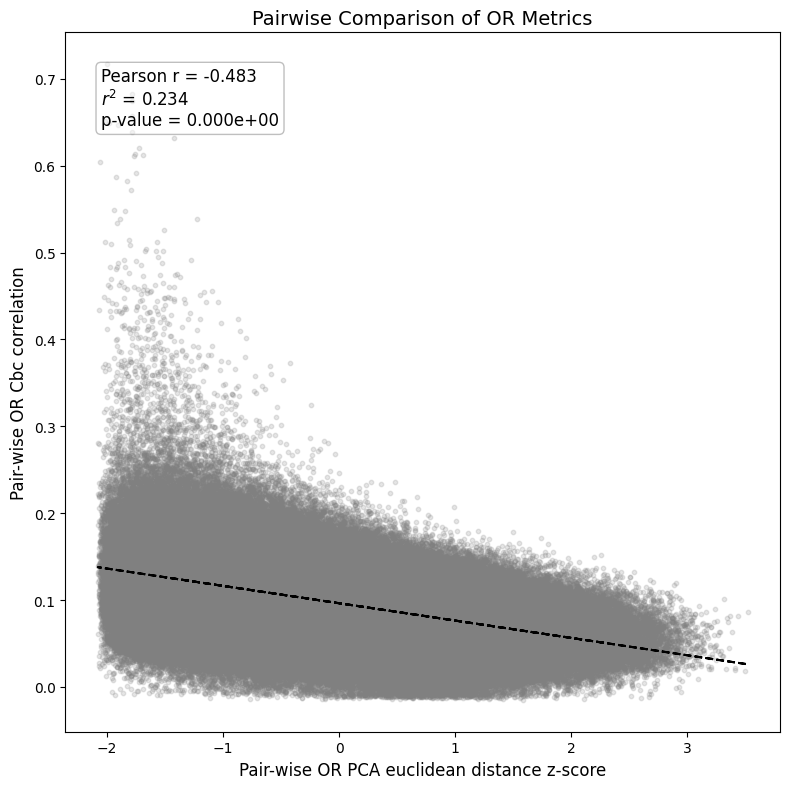

In [102]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# Get common sets of OR between pS6-IP and bc corr_df
shared_OR = list(set.intersection(set(corr_df.index), set(PCA_Cbc_df.index)))
PCA_Cbc_df = PCA_Cbc_df.loc[PCA_Cbc_df.index.isin(shared_OR)][np.sort(shared_OR)]

# Extract the upper triangular indices (excluding the diagonal)
triu_indices = np.triu_indices_from(np.array(PCA_Cbc_df), k=1)
values1 = np.array(PCA_Cbc_df)[triu_indices]
values2 = np.array(corr_df)[triu_indices]

plt = pf.plot_correlation(values1,
                          values2,
                          xlabel="Pair-wise OR PCA euclidean distance z-score",
                          ylabel="Pair-wise OR Cbc correlation",
                          title="Pairwise Comparison of OR Metrics"
)

# Show the plot
plt.tight_layout()
# plt.savefig(f'../../output/Canonical_bc/Correlation/corr_scatter_PCAzscore.png')
plt.show()

### Odor and receptor 
 Testing with 'Odor response' that's defined by Aashu. 
- https://github.com/avihani/Deorphanization/blob/main/4_Compile_descriptors_and_responses.ipynb
- https://www.biorxiv.org/content/10.1101/2021.12.27.474279v1.full.pdf

#### Grantham Distance

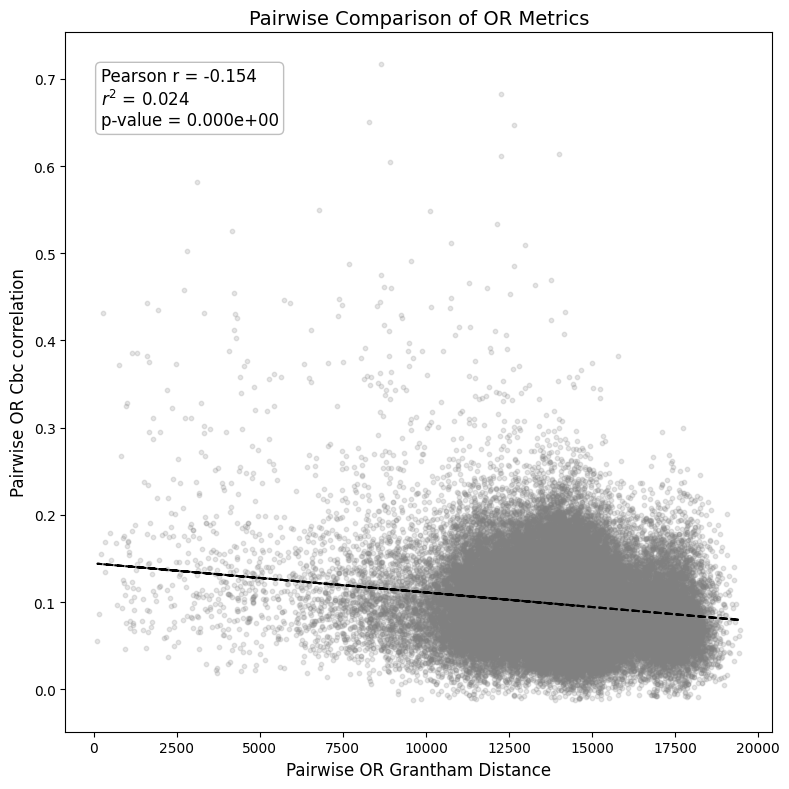

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# Read in Grantham distance table 
dist_table = pd.read_csv('../../files/Deorphanization/Resp_Olfr_distance.csv', index_col = [0,1])

dist_df = dist_table.reset_index(names=['index1', 'index2']).pivot(index='index1', columns='index2', values='olfr_dist')

# Extract the upper triangular indices (excluding the diagonal)
triu_indices = np.triu_indices_from(np.array(dist_df), k=1)

# Extract the corresponding values from both matrices
values1 = np.array(dist_df)[triu_indices]
values2 = np.array(corr_df)[triu_indices]

plt = pf.plot_correlation(values1,
                          values2,
                          xlabel="Pairwise OR Grantham Distance",
                          ylabel="Pairwise OR Cbc correlation",
                          title="Pairwise Comparison of OR Metrics"
)

# Show the plot
plt.tight_layout()
# plt.savefig(f'../../output/Canonical_bc/Correlation/corr_scatter_Cbc_olfrDist.png')
plt.show()

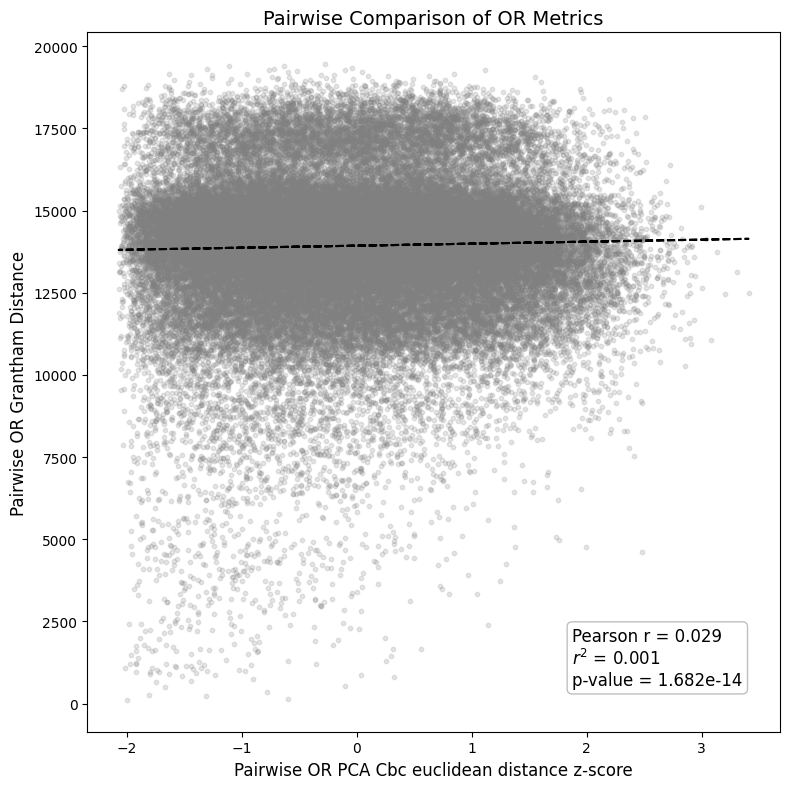

In [113]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# Read in Grantham distance table 
dist_table = pd.read_csv('../../files/Deorphanization/Resp_Olfr_distance.csv', index_col = [0,1])
dist_df = dist_table.reset_index(names=['index1', 'index2']).pivot(index='index1', columns='index2', values='olfr_dist')

# Get common sets of OR between pS6-IP and bc corr_df
shared_OR = list(set.intersection(set(dist_df.index), set(PCA_Cbc_df.index)))
values1_df = PCA_Cbc_df.loc[PCA_Cbc_df.index.isin(shared_OR)][np.sort(shared_OR)]
values2_df = dist_df.loc[dist_df.index.isin(shared_OR)][np.sort(shared_OR)]

# Extract the upper triangular indices (excluding the diagonal)
triu_indices = np.triu_indices_from(np.array(values1_df), k=1)

# Extract the corresponding values from both matrices
values1 = np.array(values1_df)[triu_indices]
values2 = np.array(values2_df)[triu_indices]

plt = pf.plot_correlation(values1,
                          values2,
                          xlabel="Pairwise OR PCA Cbc euclidean distance z-score",
                          ylabel="Pairwise OR Grantham Distance",
                          title="Pairwise Comparison of OR Metrics", 
                          text_xy = [0.7, 0.15]
)

# Show the plot
plt.tight_layout()
# plt.savefig(f'../../output/Canonical_bc/PCA/PCA_Cbc_olfrDist.png')
plt.show()

#### Testing with 'Odor response' that's defined by Aashu. 
- https://github.com/avihani/Deorphanization/blob/main/4_Compile_descriptors_and_responses.ipynb
- https://www.biorxiv.org/content/10.1101/2021.12.27.474279v1.full.pdf

In [ ]:
# # Quick parse for making distance_df. 

# # Quickly look for Olfr with the most correlated odor response
# resp_distance = pd.read_csv('../../files/Deorphanization/compiled_odor_sigResp_wide.csv', index_col=0)

# # Convert Olfr to DL_OR
# resp_distance.columns = [dict(zip(Olfr_DL.Olfr, Olfr_DL.DL_OR)).get(olfr, "Not Found") for olfr in resp_distance.columns]
# resp_distance = resp_distance[resp_distance.columns[~resp_distance.columns.isin(['Not Found'])]]
 
# resp_distance = pd.DataFrame(np.corrcoef(resp_distance.T), 
#                      index=resp_distance.columns, columns= resp_distance.columns)
# resp_distance = pd.DataFrame(resp_distance.unstack(), columns=['resp_dist'])
# # resp_distance.loc[~np.isclose(resp_distance.resp_dist, 1.00)]

# olfr_distance = pd.read_csv('../../files/Deorphanization/olfr_distances_60p_aaIdentity.csv', index_col=0)
# Olfr_DL = pd.read_csv('../../files/Olfr_DL.csv', index_col=0)
# # Convert Olfr to DL_OR
# olfr_distance.columns = [dict(zip(Olfr_DL.Olfr, Olfr_DL.DL_OR)).get(olfr, "Not Found") for olfr in olfr_distance.columns]
# olfr_distance.index = [dict(zip(Olfr_DL.Olfr, Olfr_DL.DL_OR)).get(olfr, "Not Found") for olfr in olfr_distance.index]
# olfr_distance = olfr_distance.loc[~olfr_distance.index.isin(['Not Found']),  ~olfr_distance.columns.isin(['Not Found'])
#                                   ]
# olfr_distance = pd.DataFrame(olfr_distance.unstack(), columns=['olfr_dist'])

# # olfr_distance[olfr_distance.index.get_level_values(0) == "Or2T48"].sort_values('olfr_dist')

# dist_df = pd.merge(resp_distance, olfr_distance, 
#                    left_index=True, right_index=True)
# # dist_df[~np.isclose(dist_df.resp_dist, 1.00)].sort_values(['olfr_dist', 'resp_dist'], ascending=[False, False])
# dist_df.to_csv('../../files/Deorphanization/Resp_Olfr_distance.csv')



# Olfr_DL = pd.read_csv('../../files/Olfr_DL.csv', index_col = 0)

# odor_sigResp = pd.read_csv('../../files/Deorphanization/compiled_odor_sigResp_wide.csv', index_col=0).T

# # Translate Olfr to DL_OR 
# odor_sigResp = pd.merge(odor_sigResp.reset_index(), Olfr_DL[['Olfr', 'DL_OR']], 
#          left_on='index', right_on='Olfr', how='left')\
#              .drop(['index', 'Olfr'], axis=1)\
#                  .set_index('DL_OR')

# # Calculate correlation in odor response
# odorResp_corr_df = pd.DataFrame(np.corrcoef(odor_sigResp), 
#                            columns=odor_sigResp.index, 
#                            index=odor_sigResp.index)
# pS6_corr_df.to_csv('../../output/Canonical_bc/Correlation/odorResp_corr_df', index=0)

##### Odor response

In [94]:
import importlib 

importlib.reload(bc)
importlib.reload(vf)
importlib.reload(pf)

<module 'plot_functions' from '/data/jlu/OR_learning/utils/plot_functions.py'>

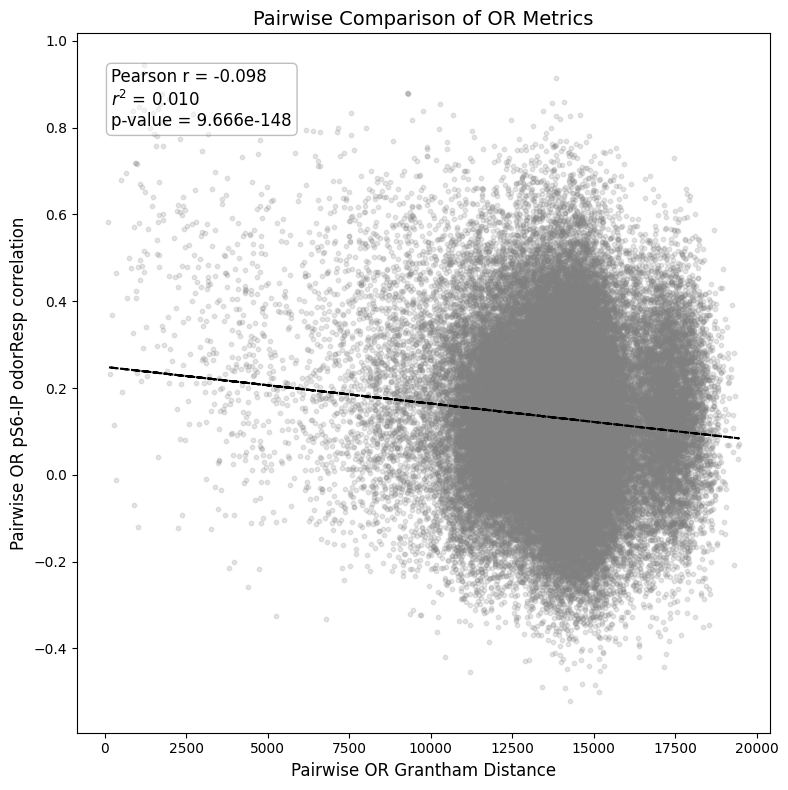

In [95]:
# Visualize the original correlation between grantham distance and odor response 

import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# Read in Grantham distance table 
dist_table = pd.read_csv('../../files/Deorphanization/Resp_Olfr_distance.csv', index_col = [0,1])
dist_df = dist_table.reset_index(names=['index1', 'index2']).pivot(index='index1', columns='index2', values='olfr_dist')
resp_df = dist_table.reset_index(names=['index1', 'index2']).pivot(index='index1', columns='index2', values='resp_dist')

# Extract the upper triangular indices (excluding the diagonal)
triu_indices = np.triu_indices_from(np.array(dist_df), k=1)

# Extract the corresponding values from both matrices
values1 = np.array(dist_df)[triu_indices]
values2 = np.array(resp_df)[triu_indices]

plt = pf.plot_correlation(values1,
                          values2,
                          xlabel="Pairwise OR Grantham Distance",
                          ylabel="Pairwise OR pS6-IP odorResp correlation",
                          title="Pairwise Comparison of OR Metrics"
)

# plt.savefig(f'../../output/Canonical_bc/Correlation/corr_scatter_odorResp_OlfrDist.png')
plt.show()

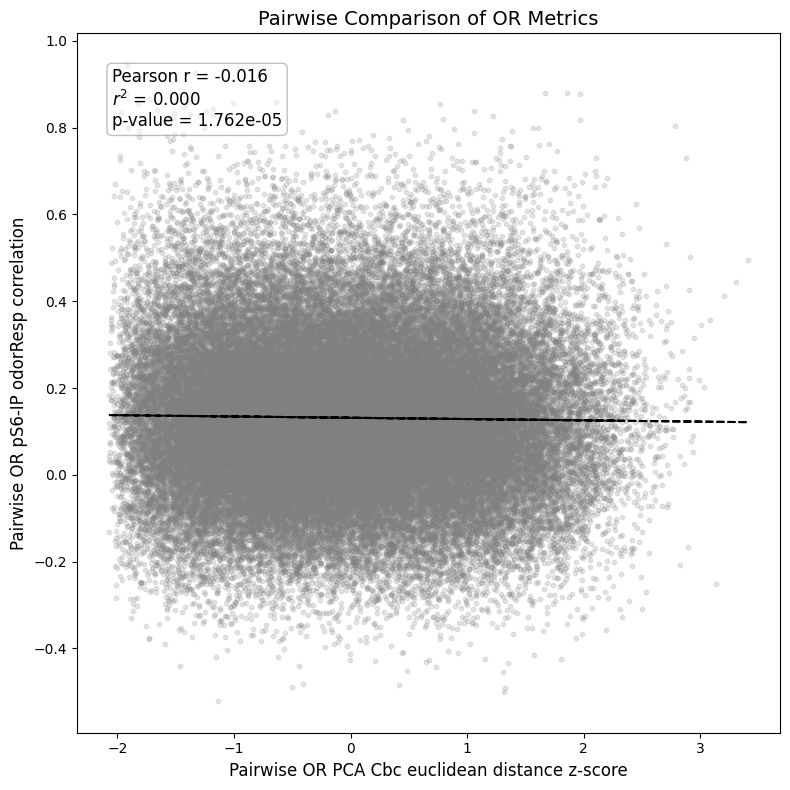

In [121]:

# Read in Grantham distance table 
dist_table = pd.read_csv('../../files/Deorphanization/Resp_Olfr_distance.csv', index_col = [0,1])
resp_df = dist_table.reset_index(names=['index1', 'index2']).pivot(index='index1', columns='index2', values='resp_dist')

# Get common sets of OR between pS6-IP and bc corr_df
shared_OR = list(set.intersection(set(resp_df.index), set(PCA_Cbc_df.index)))
values1_df = PCA_Cbc_df.loc[PCA_Cbc_df.index.isin(shared_OR)][np.sort(shared_OR)]
values2_df = resp_df.loc[resp_df.index.isin(shared_OR)][np.sort(shared_OR)]

# Extract the upper triangular indices (excluding the diagonal)
triu_indices = np.triu_indices_from(np.array(values1_df), k=1)

# Extract the corresponding values from both matrices
values1 = np.array(values1_df)[triu_indices]
values2 = np.array(values2_df)[triu_indices]

plt = pf.plot_correlation(values1,
                          values2,
                          xlabel="Pairwise OR PCA Cbc euclidean distance z-score",
                          ylabel="Pairwise OR pS6-IP odorResp correlation",
                          title="Pairwise Comparison of OR Metrics"
)

# plt.savefig(f'../../output/Canonical_bc/PCA/PCA_Cbc_odorResp.png')
plt.show()

### Grantham Distance via structural alignment 

In [ ]:
"""
# TODO Do a test case for sulfur responding residues 

# TODO Use same Strcuture aligned OBR and extract 3d coords and pca

# TODO pull sequences from Acetophenone on mds map 
that are close together in full then compare sequence
in Cbc to see if the sequence is indeed different  

# TODO maximize difference between primary sequence vs structural information 

"""

#### TEST CASE Sulfur

Sulfur test case is using the 3 experimentally determined critical sequence to determine if grantham distance MDS can capture / cluster the receptors responding to Sulfur using the 3 residue sequence alignments. 

Residue based off Or2T43 <br>
C200, C201, M204

In [374]:
# Making Grantham MDS dataframe
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()

alignment = pd.read_pickle(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_SeqAlignment_Full.pkl'))
alignment = {Olfr_DL.get(_OR, _OR):alignment[_OR] for _OR in list(alignment.keys())}
alignment = { _OR: alignment[_OR] for _OR in np.sort(list(alignment.keys()))}


In [ ]:

# Trimming alignment sequences to reduce highly gapped region
filtered_alignment, frequency_matrix = sa.trim_alignment(alignment, gap_threshold=0.5)
aligned_sequence = alignment['Or2T43']
filtered_sequence = ''.join(filtered_alignment[list(alignment.keys()).index('Or2T43')])

# Selecting 10 residues spanning the sulfur binding residue C200, C201, M204
# residue_range = list(range(195,206))
residue_range = [199,200,203]
target_residues = [f'{''.join(alignment['Or2T43'].replace('-',''))[_idx]}{_idx+1}' for _idx in residue_range]
filter_mapping = sa.map_residues_to_filtered(aligned_sequence, 
                            filtered_sequence, 
                            target_residues)

# Get separate highlight mapping for highlighting 
highlight_mapping = sa.map_residues_to_filtered(aligned_sequence, 
                            filtered_sequence, 
                            ['C200', 'C201', 'M204'])
highlight_iter = iter(list(highlight_mapping.keys()))
highlight_mapping = {next(highlight_iter): i for i, _idx in enumerate(residue_range) if _idx in list(highlight_mapping.values())}

# Extract updated target_residue positions to filtered positions then filter matrix by target_residues 
filter_mapping_pos = [filter_mapping[_res]-1 for _res in filter_mapping]
filtered_alignment = filtered_alignment[:, filter_mapping_pos]
frequency_matrix = frequency_matrix[:, filter_mapping_pos]

# Plotting weblogo 
fig = pf.plot_weblogo(frequency_matrix, 
                      highlight_index=highlight_mapping, 
                      highlight_text_color="black", 
                      highlight_text_size=12, 
                      figsize=[15,4],
                      row_length=30,
                      plot_title='Sulfur responding residue via Structural alignment (residue id via Or2T43)', 
                      show_axticks=False)

# fig.savefig('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBR.png')
# fig.savefig('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBRstrict.png')

In [ ]:
"""
Calculate pairwise Grantham Distances  
"""

# Remake sequence alignment variable from filtered_alignment 
SBR_alignment = { _key: ''.join(filtered_alignment[i]) for i, _key in enumerate(alignment.keys())}
SBR_alignment = { _OR: SBR_alignment[_OR] for _OR in np.sort(list(SBR_alignment.keys()))}

filtered_alignment, _ = sa.trim_alignment(SBR_alignment, gap_threshold=0.5)
filtered_alignment = {list(SBR_alignment.keys())[i] : "".join(_seq) for i, _seq in enumerate(filtered_alignment)}
SBR_mds_coords, SBR_dist_mtx = sa.grantham_mds_projection(list(filtered_alignment.values()), 
                                                          aggregate='mean', gap_handling='ignore')

SBR_dist_mtx = pd.DataFrame(SBR_dist_mtx, columns = SBR_alignment.keys(), index = SBR_alignment.keys())
SBR_mds_coords = pd.DataFrame(SBR_mds_coords, columns = ['MDS1', 'MDS2'], index = SBR_alignment.keys())

# SBR_dist_mtx.to_csv('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBR_grantham_dist_mtx.csv')
# SBR_mds_coords.to_csv('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBR_grantham_mds_coords.csv')

In [ ]:

# Extract OR class from index
OR_class = [re.match(r'Or(\d+)', _OR).group(1) if re.match(r'Or(\d+)', _OR) else 'None' for _OR in SBR_mds_coords.index]

# Define Class I and Class II based on OR number ranges
Class_I_df = SBR_mds_coords.loc[[_OR for _OR, cls in zip(SBR_mds_coords.index, OR_class) if cls in map(str, range(51, 57))]]
Class_II_df = SBR_mds_coords.loc[[_OR for _OR, cls in zip(SBR_mds_coords.index, OR_class) if cls in map(str, range(1, 15))]]

# Define colors for each class
colormap = cf.distinct_colors(['Class_I', 'Class_II'])

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=Class_I_df.iloc[:, 0],  # First dimension
    y=Class_I_df.iloc[:, 1],  # Second dimension
    text=Class_I_df.index,    # Labels
    mode='markers',
    name='Class_I',
    marker=dict(
        color=colormap['Class_I'],
        size = 8, opacity=0.6
    )
))

fig.add_trace(go.Scatter(
    x=Class_II_df.iloc[:, 0],
    y=Class_II_df.iloc[:, 1],
    text=Class_II_df.index,
    mode='markers',
    name='Class_II',
    marker=dict(
        color=colormap['Class_II'],
        size = 8, opacity=0.6
    )
))

# Update layout
fig.update_layout(template='simple_white')
# fig.write_html('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBR_grantham_mds_Class.html')
# fig.write_html('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBRstrict_grantham_mds_Class.html')
fig.show()

In [ ]:
"""
Visualize MDS by Family 
"""
# Load data
alignment = pd.read_pickle('../../files/binding_cavity/dict_SeqAlignment_Full.pkl')
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()

# Maintain alignment dictionary keys
alignment_keys = [Olfr_DL.get(_key, _key) for _key in alignment.keys()]

# Extract OR family classification from names
alignment_OR_class = {
    _OR: re.match(r'Or(\d+)', _OR).group(1) if re.match(r'Or(\d+)', _OR) else 'None'
    for _OR in alignment_keys
}

# Define OR families to be plotted
OR_family = list(map(str, range(1, 15))) + list(map(str, range(51, 57)))
colormap = cf.distinct_colors(OR_family, category='tab20')

# Initialize figure
fig = go.Figure()

# Iterate through OR families and add traces
for _OR_fam in OR_family:
    # Select ORs belonging to the current family
    ORs_in_family = [OR for OR, fam in alignment_OR_class.items() if fam == _OR_fam]

    # Ensure family exists in mds_coords
    family_df = SBR_mds_coords.loc[SBR_mds_coords.index.intersection(ORs_in_family)]

    if not family_df.empty:
        fig.add_trace(go.Scatter(
            x=family_df.iloc[:, 0], 
            y=family_df.iloc[:, 1], 
            text=family_df.index, 
            mode='markers',
            name=f'Or{_OR_fam} family', 
            marker=dict(
                color=colormap[_OR_fam],
                size=8, 
                opacity=0.6
            )
        ))

# Apply layout settings
fig.update_layout(template='simple_white')
fig = pf._plotly_fixed_axes_ranges(fig)
fig.show()

# fig.write_html('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBR_grantham_mds_family.html')
# fig.write_html('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBRstrict_grantham_mds_family.html')

In [ ]:
label = ['Or2T43', 'Or2T45', 'Or1Ad1']

# Define colors for each class
colormap = cf.distinct_colors(['label', 'temp'])

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=SBR_mds_coords.iloc[:, 0],  # First dimension
    y=SBR_mds_coords.iloc[:, 1],  # Second dimension
    text=SBR_mds_coords.index,    # Labels
    mode='markers',
    name='i',
    marker=dict(
        color='#D3D3D3',
        size = 8, opacity=0.6
    )
))


fig.add_trace(go.Scatter(
    x=SBR_mds_coords.loc[label].iloc[:, 0],  # First dimension
    y=SBR_mds_coords.loc[label].iloc[:, 1],  # Second dimension
    text=SBR_mds_coords.loc[label].index,    # Labels
    mode='markers',
    name='label',
    marker=dict(
        color=colormap['label'],
        size = 8, opacity=0.6
    )
))

# Update layout
fig.update_layout(template='simple_white')
fig.show()

In [ ]:
"""
Visualize individual MDS by pS6 logFC 
"""
from plotly.subplots import make_subplots

logFC_cutoff = 2
FDR_cutoff = 0.1

# Load data
# SBR_mds_coords = pd.read_csv('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBR_grantham_mds_coords.csv', index_col=0)
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()
pS6_df = pd.read_csv('../../files/pS6IP_MASTER_HL_Annotated_2024.csv')[['DL_OR', 'odor_and_conc', 'odor_category', 'logFC', 'FDR']]
pS6_df = pS6_df.loc[(pS6_df.odor_category == 'Sulfurous') | 
                    # (pS6_df.odor_category == 'Thiazole') | 
                    (pS6_df.odor_and_conc.str.contains('Acetophenone'))]


# Determine subplot grid size
odors = pS6_df.odor_and_conc.unique()
num_odors = len(odors)
cols = 4  # Columns in the facet grid
rows = -(-num_odors // cols)  # Ceiling division

# Filter for DL only OR and Identify overlapping ORs 
SBR_mds_coords = SBR_mds_coords.iloc[SBR_mds_coords.index.str.startswith('Or')]
OR_overlap = set(SBR_mds_coords.index).intersection(set(pS6_df.DL_OR.unique()))
pS6_df = pS6_df[pS6_df.DL_OR.isin(OR_overlap)] # Filter pS6_df for overlapped OR 


# Create subplots
fig = make_subplots(
    rows=rows, cols=cols, 
    subplot_titles=[str(_odor) for _odor in odors],
    horizontal_spacing=0.05, vertical_spacing=0.1
)

# Generate facet plots
for i, _odor in enumerate(odors):
    row, col = divmod(i, cols)
    row += 1  
    col += 1  

    # Get response values and corresponding ORs
    _odor_pS6_df = pS6_df[pS6_df.odor_and_conc == _odor].set_index('DL_OR')
    _odor_pS6_df = _odor_pS6_df[((_odor_pS6_df.logFC >= logFC_cutoff) | (_odor_pS6_df.logFC <= -logFC_cutoff)) & 
                                (_odor_pS6_df.FDR <= FDR_cutoff)].sort_values('logFC')
    
    logFC_values = _odor_pS6_df.logFC.sort_values()
    FDR_values = _odor_pS6_df.FDR
    
    odor_OR_df = SBR_mds_coords.reindex(logFC_values.index)
    
    # Separate background ORs
    background_df = SBR_mds_coords.iloc[~SBR_mds_coords.index.isin(odor_OR_df.index)]


    # Generate colormap
    colormap = cf.get_continuous_colors(logFC_values, colormap="RdBu_r", 
                                        midpoint=0)

    # Hover text formatting
    hover_texts = logFC_values.apply(lambda val: f"{val:.3f}").tolist()
    hover_texts = [f"{or_name}<br>logFC:{logFC_values[or_name]:.3f}<br>FDR:{FDR_values[or_name]:.2}" for or_name in odor_OR_df.index]


    # Background ORs
    fig.add_trace(go.Scatter(
        x=background_df.iloc[:, 0], 
        y=background_df.iloc[:, 1],
        text=background_df.index,
        mode="markers",
        marker=dict(color="#D3D3D3", size=8, opacity=0.1),
        showlegend=False,
    ), row=row, col=col)

    # Odor-responsive ORs
    fig.add_trace(go.Scatter(
        x=odor_OR_df.iloc[:, 0], 
        y=odor_OR_df.iloc[:, 1],
        text=hover_texts,
        mode="markers",
        marker=dict(color=[colormap[or_name] for or_name in logFC_values.index], 
                    size=8, opacity=0.8),
        showlegend=False,
    ), row=row, col=col)

# Layout properties
fig.update_layout(
    template="simple_white",
    title="Odor Response Facet Plot",
    height=rows * 300, width=cols * 300
)

# Show the plot
fig.show()
fig = pf._plotly_fixed_axes_ranges(fig)

# fig.write_html('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBR_grantham_mds_OdorResp.html')
fig.write_html('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBRstrict_grantham_mds_OdorResp.html')

In [ ]:
print('Or2T45 cluster')
for _OR in ['Or2T45', 'Or2T44', 'Or2T43', 'Or2T47', 'Or2V2', 'Or2T1']: 
    print(SBR_alignment[_OR])
print('Far cluster')
for _OR in ['Or4K49', 'Or4L15', 'Or4C31']: 
    print(SBR_alignment[_OR])

Or2T45 cluster
CCM
CCM
CCM
CCM
CCM
CCM
non responding
DCV
SGL
NSI


In [ ]:
import random 

# Load data 
Full_dist_mtx = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full_grantham_dist_mtx.csv', index_col = 0)
OBR_dist_mtx  = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_OBR_grantham_dist_mtx.csv', index_col = 0)
# SBR_dist_mtx  = pd.read_csv('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBR_grantham_dist_mtx.csv', index_col = 0)

# Load other required files
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()
pS6_df = pd.read_csv('../../files/pS6IP_MASTER_HL_Annotated_2024.csv')[['DL_OR', 'odor_and_conc', 'odor_category', 'logFC', 'FDR']]
pS6_df = pS6_df.loc[(pS6_df.odor_category == 'Sulfurous') | 
                    # (pS6_df.odor_category == 'Thiazole') | 
                    (pS6_df.odor_and_conc.str.contains('Acetophenone'))]
odors = pS6_df.odor_and_conc.unique()

# Define cutoffs for to filter 
logFC_cutoff = 2
FDR_cutoff = 0.1
odor_differences = []

# For creating shuffle 
all_ORs = list(Full_dist_mtx.index)  
matrices = {
    "Full": Full_dist_mtx,
    "OBR": OBR_dist_mtx,
    "SBR": SBR_dist_mtx  # Assuming OBR also uses Cbc_dist_norm
}

# Iterate through each odor and collect pairwise distances from the precomputed **scaled** distance matrices
for _odor in odors:
    
    # Identify overlapping ORs present in both datasets
    OR_overlap = set(pS6_df[pS6_df.odor_and_conc == _odor].DL_OR).intersection(Full_dist_mtx.index)
 
    # Get response values and corresponding ORs
    _odor_pS6_df = pS6_df[pS6_df.odor_and_conc == _odor].set_index('DL_OR')
    _odor_pS6_df = _odor_pS6_df[((_odor_pS6_df.logFC >= logFC_cutoff) | (_odor_pS6_df.logFC <= -logFC_cutoff)) & 
                                (_odor_pS6_df.FDR <= FDR_cutoff)].sort_values('logFC')
    
        
    # Get OR responses sorted by value
    pos_response_ORs = _odor_pS6_df[_odor_pS6_df.logFC > logFC_cutoff].index  # Select ORs with > logFC

    if len(pos_response_ORs) >= 2:
        # Compute pairwise distances using the **scaled** Grantham distance matrices
        for i in range(len(pos_response_ORs)):
            for j in range(i + 1, len(pos_response_ORs)):
                or1, or2 = pos_response_ORs[i], pos_response_ORs[j]

                # Extract distances from the **scaled** matrices
                odor_differences.append([_odor, "Full", Full_dist_mtx.loc[or1, or2]]) if or1 in Full_dist_mtx.index and or2 in Full_dist_mtx.columns else None
                odor_differences.append([_odor, "OBR", OBR_dist_mtx.loc[or1, or2]]) if or1 in OBR_dist_mtx.index and or2 in OBR_dist_mtx.columns else None                
                odor_differences.append([_odor, "SBR", SBR_dist_mtx.loc[or1, or2]]) if or1 in SBR_dist_mtx.index and or2 in SBR_dist_mtx.columns else None


    for label, dist_mtx in matrices.items():
        shuffled_ORs = random.sample(all_ORs, len(pos_response_ORs))
        for i, or1 in enumerate(shuffled_ORs):
            for or2 in shuffled_ORs[i + 1:]:  # Avoid duplicate pairs
                if or1 in dist_mtx.index and or2 in dist_mtx.columns:
                    odor_differences.append([_odor, f'{label}_shuffle', dist_mtx.loc[or1, or2]])
        
                    
# Convert to DataFrame
odor_differences_df = pd.DataFrame(odor_differences, columns=['odor', 'Condition', 'Pairwise_Difference'])
odor_summary = odor_differences_df.groupby(['odor', 'Condition'])['Pairwise_Difference'].agg(['mean', 'std']).reset_index()

# Pivot for easy access to shuffle means and standard deviations
pivot_df = odor_summary.pivot(index="odor", columns="Condition", values=["mean", "std"])
normalized_values = []
for cond in ["Full", "OBR", "SBR"]:
    shuffle_cond = f"{cond}_shuffle"
    
    # Compute mean and std normalization
    normalized_mean = pivot_df[("mean", cond)] / pivot_df[("mean", shuffle_cond)]
    normalized_std = pivot_df[("std", cond)] / pivot_df[("mean", shuffle_cond)]  # Std normalization

    # Store results
    for odor in odor_summary["odor"].unique():
        normalized_values.append({
            "odor": odor,
            "Condition": cond,
            "normalized_mean": normalized_mean.loc[odor],
            "normalized_std": normalized_std.loc[odor]
        })
normalized_df = pd.DataFrame(normalized_values)
normalized_df = normalized_df.replace(np.nan, 0) # Replace nan with 0 

# Define color mapping
# Plot_condition = ['Full', 'OBR', 'SBR']
# colormap = cf.distinct_colors(Plot_condition)

Plot_condition = normalized_df.Condition.unique()
colormap = cf.distinct_colors([i for i in Plot_condition if 'shuffle' not in i])

sorted_odor = list(odors)
# Create figure with grouped scatter mode
fig = go.Figure(
    layout=dict(
        xaxis=dict(categoryorder="array", categoryarray=sorted_odor),
        yaxis_title="Pairwise Grantham Distance",
        scattermode="group",
        legend=dict(groupclick="toggleitem"),
        template="simple_white"
    )
)

# Add bar plots (Mean & Std) for **Full** and **Cbc**
for _condition in Plot_condition:
    condition_data = normalized_df[normalized_df[f"Condition"] == _condition]
    fig.add_trace(go.Bar(
        x=condition_data["odor"],
        y=condition_data["normalized_mean"],
        error_y=dict(type='data', 
                     array=condition_data["normalized_std"],
                     color=colormap[_condition]),
        name=_condition,
        # marker=dict(color=colormap[_condition], opacity=0.7),
        marker=dict(color=colormap[_condition], opacity=0.7) if 'shuffle' not in _condition \
            else dict(color='#D3D3D3', opacity=0.5),
        offsetgroup=_condition,
        legendgroup=_condition
    ))

# Show plot
fig.show()
fig.write_html('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBRstrict_grantham_PairwiseDist_normalized.html')


In [ ]:
import random 

# Load data 
Full_dist_mtx = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full_grantham_dist_mtx.csv', index_col = 0)
OBR_dist_mtx  = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_OBR_grantham_dist_mtx.csv', index_col = 0)
# SBR_dist_mtx  = pd.read_csv('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBR_grantham_dist_mtx.csv', index_col = 0)

# Load other required files
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()
pS6_df = pd.read_csv('../../files/pS6IP_MASTER_HL_Annotated_2024.csv')[['DL_OR', 'odor_and_conc', 'odor_category', 'logFC', 'FDR']]
pS6_df = pS6_df.loc[(pS6_df.odor_category == 'Sulfurous') | 
                    # (pS6_df.odor_category == 'Thiazole') | 
                    (pS6_df.odor_and_conc.str.contains('Acetophenone'))]
odors = pS6_df.odor_and_conc.unique()

# Define cutoffs for to filter 
logFC_cutoff = 2
FDR_cutoff = 0.1
odor_differences = []

# For creating shuffle 
all_ORs = list(Full_dist_mtx.index)  
matrices = {
    "Full": Full_dist_mtx,
    "OBR": OBR_dist_mtx,
    "SBR": SBR_dist_mtx  # Assuming OBR also uses Cbc_dist_norm
}

# Iterate through each odor and collect pairwise distances from the precomputed **scaled** distance matrices
for _odor in odors:
    
    # Identify overlapping ORs present in both datasets
    OR_overlap = set(pS6_df[pS6_df.odor_and_conc == _odor].DL_OR).intersection(Full_dist_mtx.index)
 
    # Get response values and corresponding ORs
    _odor_pS6_df = pS6_df[pS6_df.odor_and_conc == _odor].set_index('DL_OR')
    _odor_pS6_df = _odor_pS6_df[((_odor_pS6_df.logFC >= logFC_cutoff) | (_odor_pS6_df.logFC <= -logFC_cutoff)) & 
                                (_odor_pS6_df.FDR <= FDR_cutoff)].sort_values('logFC')
    
        
    # Get OR responses sorted by value
    pos_response_ORs = _odor_pS6_df[_odor_pS6_df.logFC > logFC_cutoff].index  # Select ORs with > logFC

    if len(pos_response_ORs) >= 2:
        # Compute pairwise distances using the **scaled** Grantham distance matrices
        for i in range(len(pos_response_ORs)):
            for j in range(i + 1, len(pos_response_ORs)):
                or1, or2 = pos_response_ORs[i], pos_response_ORs[j]

                # Extract distances from the **scaled** matrices
                odor_differences.append([_odor, "Full", Full_dist_mtx.loc[or1, or2]]) if or1 in Full_dist_mtx.index and or2 in Full_dist_mtx.columns else None
                odor_differences.append([_odor, "OBR", OBR_dist_mtx.loc[or1, or2]]) if or1 in OBR_dist_mtx.index and or2 in OBR_dist_mtx.columns else None                
                odor_differences.append([_odor, "SBR", SBR_dist_mtx.loc[or1, or2]]) if or1 in SBR_dist_mtx.index and or2 in SBR_dist_mtx.columns else None


    for label, dist_mtx in matrices.items():
        shuffled_ORs = random.sample(all_ORs, len(pos_response_ORs))
        for i, or1 in enumerate(shuffled_ORs):
            for or2 in shuffled_ORs[i + 1:]:  # Avoid duplicate pairs
                if or1 in dist_mtx.index and or2 in dist_mtx.columns:
                    odor_differences.append([_odor, f'{label}_shuffle', dist_mtx.loc[or1, or2]])
        
                    
# Convert to DataFrame
odor_differences_df = pd.DataFrame(odor_differences, columns=['odor', 'Condition', 'Pairwise_Difference'])
odor_summary = odor_differences_df.groupby(['odor', 'Condition'])['Pairwise_Difference'].agg(['mean', 'std']).reset_index()
# shuffle_summary = pd.DataFrame(shuffle_diff, columns=['Condition', 'dist']).groupby(['Condition'])['dist'].mean()

# Define color mapping
# Plot_condition = ['Full', 'OBR', 'SBR']
# colormap = cf.distinct_colors(Plot_condition)

Plot_condition = odor_summary.Condition.unique()
colormap = cf.distinct_colors([i for i in Plot_condition if 'shuffle' not in i])

sorted_odor = ['Shuffle'] + list(odors)
# Create figure with grouped scatter mode
fig = go.Figure(
    layout=dict(
        xaxis=dict(categoryorder="array", categoryarray=sorted_odor),
        yaxis_title="Pairwise Grantham Distance",
        scattermode="group",
        legend=dict(groupclick="toggleitem"),
        template="simple_white"
    )
)

# Add bar plots (Mean & Std) for **Full** and **Cbc**
for _condition in Plot_condition:
    condition_data = odor_summary[odor_summary["Condition"] == _condition]
    fig.add_trace(go.Bar(
        x=condition_data["odor"],
        y=condition_data["mean"],
        name=_condition,
        # marker=dict(color=colormap[_condition], opacity=0.7),
        marker=dict(color=colormap[_condition], opacity=0.7) if 'shuffle' not in _condition \
            else dict(color='#D3D3D3', opacity=0.5),
        offsetgroup=_condition,
        legendgroup=_condition
    ))

for _condition in Plot_condition:
    condition_data = odor_differences_df[odor_differences_df["Condition"] == _condition]
    fig.add_trace(go.Scatter(
        x=condition_data["odor"],
        y=condition_data["Pairwise_Difference"],
        mode="markers",
        name=_condition,
        # marker=dict(color=colormap[_condition], size=5, opacity=0.3, symbol="circle"),
        marker=dict(color=colormap[_condition], size=5, opacity=0.3, symbol="circle") if 'shuffle' not in _condition \
            else dict(color='#D3D3D3',size=5, opacity=0.3, symbol="circle"),
        offsetgroup=_condition
        # legendgroup=_condition,
        # showlegend=False
    ))

# Show plot
fig.show()
# fig.write_html('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBR_grantham_PairwiseDist.html')
fig.write_html('../../output/Canonical_bc/TEST_Sulfur/SeqAlignment_SBRstrict_grantham_PairwiseDist.html')

#### Full sequence Structure Sequence Alignement 

In [213]:
# Making Grantham MDS dataframe
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()

alignment = pd.read_pickle(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_SeqAlignment_Full.pkl'))
alignment = {Olfr_DL.get(_OR, _OR):alignment[_OR] for _OR in list(alignment.keys())}
alignment = { _OR: alignment[_OR] for _OR in np.sort(list(alignment.keys()))}

filtered_alignment, _ = sa.trim_alignment(alignment, gap_threshold=0.5)
filtered_alignment = {list(alignment.keys())[i] : "".join(_seq) for i, _seq in enumerate(filtered_alignment)}
mds_coords, dist_mtx = sa.grantham_mds_projection(list(filtered_alignment.values()), aggregate='mean', gap_handling='ignore')

pd.DataFrame(dist_mtx, 
             columns = alignment.keys(), 
             index = alignment.keys()).to_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full_grantham_dist_mtx.csv')
pd.DataFrame(mds_coords, 
             columns = ['MDS1', 'MDS2'], 
             index = alignment.keys()).to_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full_grantham_mds_coords.csv')

In [ ]:
# alignment = pd.read_pickle('../../files/binding_cavity/dict_SeqAlignment_Full.pkl')
# mds_coords = sa.grantham_mds_projection(list(alignment.values()), aggregate='mean', gap_handling='ignore')
# # np.save('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full_grantham_mds_coords', mds_coords)

In [ ]:
"""
Visualize MDS by Class 
"""
# Load data
alignment = pd.read_pickle('../../files/binding_cavity/dict_SeqAlignment_Full.pkl')
mds_coords = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full_grantham_mds_coords.csv', index_col=0)
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()

# Convert OR keys using Olfr_DL mapping
alignment_ORs = [Olfr_DL.get(_key, _key) for _key in alignment.keys()]

# Classify ORs into Class I or Class II
alignment_df = pd.DataFrame({'OR': alignment_ORs})
alignment_df['Class'] = alignment_df['OR'].apply(
    lambda x: 'Class_I' if re.match(r'Or(5[1-6])', x) else ('Class_II' if re.match(r'Or(1[0-4]|\d)', x) else 'None')
)

# Filter DataFrame based on class
class_I_df = mds_coords.loc[alignment_df[alignment_df['Class'] == 'Class_I']['OR']]
class_II_df = mds_coords.loc[alignment_df[alignment_df['Class'] == 'Class_II']['OR']]

# Define colormap
colormap = cf.distinct_colors(['Class_I', 'Class_II'], category='tab10')

# Create figure
fig = go.Figure()

# Plot Class I
fig.add_trace(go.Scatter(
    x=class_I_df.iloc[:, 0], 
    y=class_I_df.iloc[:, 1], 
    text=class_I_df.index,
    mode='markers',
    name='Class_I', 
    marker=dict(color=colormap['Class_I'], size=8, opacity=0.6)
))

# Plot Class II
fig.add_trace(go.Scatter(
    x=class_II_df.iloc[:, 0], 
    y=class_II_df.iloc[:, 1], 
    text=class_II_df.index,
    mode='markers',
    name='Class_II', 
    marker=dict(color=colormap['Class_II'], size=8, opacity=0.6)
))

# Finalize layout
fig.update_layout(template='simple_white')
fig = pf._plotly_fixed_axes_ranges(fig)
# Show the plot
fig.show()
fig.write_html('../../output/Canonical_bc/Grantham_distance/SeqAlignment_grantham_mds_Class.html')

In [ ]:
"""
Visualize MDS by Family 
"""
# Load data
alignment = pd.read_pickle('../../files/binding_cavity/dict_SeqAlignment_Full.pkl')
mds_coords = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full_grantham_mds_coords.csv', index_col=0)
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()

# Ensure mds_coords keeps identity without changing structure
mds_coords.index = [Olfr_DL.get(_OR, _OR) for _OR in mds_coords.index]
mds_coords.columns = [Olfr_DL.get(_OR, _OR) for _OR in mds_coords.columns]

# Maintain alignment dictionary keys
alignment_keys = [Olfr_DL.get(_key, _key) for _key in alignment.keys()]

# Extract OR family classification from names
alignment_OR_class = {
    _OR: re.match(r'Or(\d+)', _OR).group(1) if re.match(r'Or(\d+)', _OR) else 'None'
    for _OR in alignment_keys
}

# Define OR families to be plotted
OR_family = list(map(str, range(1, 15))) + list(map(str, range(51, 57)))
colormap = cf.distinct_colors(OR_family, category='tab20')

# Initialize figure
fig = go.Figure()

# Iterate through OR families and add traces
for _OR_fam in OR_family:
    # Select ORs belonging to the current family
    ORs_in_family = [OR for OR, fam in alignment_OR_class.items() if fam == _OR_fam]

    # Ensure family exists in mds_coords
    family_df = mds_coords.loc[mds_coords.index.intersection(ORs_in_family)]

    if not family_df.empty:
        fig.add_trace(go.Scatter(
            x=family_df.iloc[:, 0], 
            y=family_df.iloc[:, 1], 
            text=family_df.index, 
            mode='markers',
            name=f'Or{_OR_fam} family', 
            marker=dict(
                color=colormap[_OR_fam],
                size=8, 
                opacity=0.6
            )
        ))

# Apply layout settings
fig.update_layout(template='simple_white')
fig = pf._plotly_fixed_axes_ranges(fig)
fig.show()

fig.write_html('../../output/Canonical_bc/Grantham_distance/SeqAlignment_grantham_mds_family.html')

In [ ]:
"""
Visualize individual MDS by odor response 
"""
from plotly.subplots import make_subplots

# Load data
mds_coords = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full_grantham_mds_coords.csv', index_col=0)
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()
odorResp_df = pd.read_csv('../../files/Deorphanization/compiled_odor_sigResp_wide.csv', index_col=0)
cid_name = dict(pd.read_csv('../../files/Deorphanization/cid_odornames.csv', index_col=0)[['cid', 'name']].values)

# Map OR and odor names
odorResp_df.index = odorResp_df.index.map(lambda cid: cid_name.get(cid, cid))
odorResp_df.columns = odorResp_df.columns.map(Olfr_DL.get)
odorResp_df = odorResp_df.sort_index()

# Determine subplot grid size
num_odors = len(odorResp_df)
cols = 4  # Columns in the facet grid
rows = -(-num_odors // cols)  # Ceiling division

# Identify overlapping ORs
OR_overlap = set(odorResp_df.columns).intersection(mds_coords.index)

# Filter for DL only OR 
mds_coords = mds_coords.iloc[mds_coords.index.str.startswith('Or')]

# Separate background ORs
background_df = mds_coords.iloc[~mds_coords.index.isin(OR_overlap)]

# Create subplots
fig = make_subplots(
    rows=rows, cols=cols, 
    subplot_titles=[str(odor) for odor in odorResp_df.index],
    horizontal_spacing=0.05, vertical_spacing=0.02
)

# Generate facet plots
for i, _odor in enumerate(odorResp_df.index):
    row, col = divmod(i, cols)
    row += 1  
    col += 1  

    # Get response values and corresponding ORs
    response_values = odorResp_df.loc[_odor, list(OR_overlap)].sort_values()
    odor_OR_df = mds_coords.reindex(response_values.index)

    # Generate colormap
    colormap = cf.get_continuous_colors(response_values, colormap="RdBu_r", midpoint=0)

    # Hover text formatting
    hover_texts = response_values.apply(lambda val: f"{val:.3f}").tolist()
    hover_texts = [f"{or_name}: {response_values[or_name]:.3f}" for or_name in odor_OR_df.index]


    # Background ORs
    fig.add_trace(go.Scatter(
        x=background_df.iloc[:, 0], 
        y=background_df.iloc[:, 1],
        text=background_df.index,
        mode="markers",
        marker=dict(color="#D3D3D3", size=8, opacity=0.3),
        showlegend=False,
    ), row=row, col=col)

    # Odor-responsive ORs
    fig.add_trace(go.Scatter(
        x=odor_OR_df.iloc[:, 0], 
        y=odor_OR_df.iloc[:, 1],
        text=hover_texts,
        mode="markers",
        marker=dict(color=[colormap[or_name] for or_name in response_values.index], 
                    size=8, opacity=0.8),
        showlegend=False,
    ), row=row, col=col)

# Layout properties
fig.update_layout(
    template="simple_white",
    title="Odor Response Facet Plot",
    height=rows * 300, width=cols * 300
)

# Show the plot
fig.show()
fig = pf._plotly_fixed_axes_ranges(fig)

fig.write_html('../../output/Canonical_bc/Grantham_distance/SeqAlignment_Full_grantham_mds_OdorResp.html')

#### Cbc Structure Sequence Alignement

In [219]:
Cbc_alignment = pd.read_pickle(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_SeqAlignment_Cbc.pkl'))
Cbc_alignment = { _OR: Cbc_alignment[_OR] for _OR in np.sort(list(Cbc_alignment.keys()))}

filtered_alignment, _ = sa.trim_alignment(Cbc_alignment, gap_threshold=0.5)
filtered_alignment = {list(alignment.keys())[i] : "".join(_seq) for i, _seq in enumerate(filtered_alignment)}
Cbc_mds_coords, Cbc_dist_mtx = sa.grantham_mds_projection(list(filtered_alignment.values()), aggregate='mean', gap_handling='ignore')

pd.DataFrame(Cbc_dist_mtx, 
             columns = Cbc_alignment.keys(), 
             index = Cbc_alignment.keys()).to_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Cbc_grantham_dist_mtx.csv')

pd.DataFrame(Cbc_mds_coords, 
             columns = ['MDS1', 'MDS2'], 
             index = Cbc_alignment.keys()).to_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Cbc_grantham_mds_coords.csv')

In [ ]:
# Load data (assuming Cbc_mds_coords is now a Pandas DataFrame)
Cbc_mds_coords = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Cbc_grantham_mds_coords.csv', index_col=0)

# Extract OR class from index
OR_class = [re.match(r'Or(\d+)', _OR).group(1) if re.match(r'Or(\d+)', _OR) else 'None' for _OR in Cbc_mds_coords.index]

# Define Class I and Class II based on OR number ranges
Class_I_df = Cbc_mds_coords.loc[[_OR for _OR, cls in zip(Cbc_mds_coords.index, OR_class) if cls in map(str, range(51, 57))]]
Class_II_df = Cbc_mds_coords.loc[[_OR for _OR, cls in zip(Cbc_mds_coords.index, OR_class) if cls in map(str, range(1, 15))]]

# Define colors for each class
colormap = cf.distinct_colors(['Class_I', 'Class_II'])

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=Class_I_df.iloc[:, 0],  # First dimension
    y=Class_I_df.iloc[:, 1],  # Second dimension
    text=Class_I_df.index,    # Labels
    mode='markers',
    name='Class_I',
    marker=dict(
        color=colormap['Class_I'],
        size = 8, opacity=0.6
    )
))

fig.add_trace(go.Scatter(
    x=Class_II_df.iloc[:, 0],
    y=Class_II_df.iloc[:, 1],
    text=Class_II_df.index,
    mode='markers',
    name='Class_II',
    marker=dict(
        color=colormap['Class_II'],
        size = 8, opacity=0.6
    )
))

# Update layout
fig.update_layout(template='simple_white')
fig.write_html('../../output/Canonical_bc/Grantham_distance/SeqAlignment_Cbc_grantham_mds_Class.html')
fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load data (assuming Cbc_mds_coords is now a Pandas DataFrame)
Cbc_mds_coords = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Cbc_grantham_mds_coords.csv', index_col=0)

# Load other required files
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()
odorResp_df = pd.read_csv('../../files/Deorphanization/compiled_odor_sigResp_wide.csv', index_col=0)
cid_name = dict(pd.read_csv('../../files/Deorphanization/cid_odornames.csv', index_col=0)[['cid', 'name']].values)

# Translate Olfr to DLOR and Cid to odor name
odorResp_df.columns = [Olfr_DL.get(_col) for _col in odorResp_df.columns]
odorResp_df.index = [cid_name.get(_cid, _cid) for _cid in odorResp_df.index]
odorResp_df = odorResp_df.sort_index()

# Determine subplot grid size
num_odors = len(odorResp_df.index)
cols = 4  # Number of columns in the facet grid
rows = -(-num_odors // cols)  # Ceiling division

# Identify overlapping ORs present in both datasets
OR_overlap = set(odorResp_df.columns).intersection(Cbc_mds_coords.index)

# Background ORs (not present in the overlapping set)
background_df = Cbc_mds_coords.loc[~Cbc_mds_coords.index.isin(OR_overlap)]

# Create subplot layout
fig = make_subplots(
    rows=rows, cols=cols, subplot_titles=[str(_odor) for _odor in odorResp_df.index[:num_odors]],
    horizontal_spacing=0.05, vertical_spacing=0.02
)

# Iterate through each odor and create the facet plots
for i, _odor in enumerate(odorResp_df.index[:num_odors]):
    row, col = divmod(i, cols)
    row += 1  # Plotly starts rows at 1
    col += 1  # Plotly starts cols at 1

    # Get OR responses sorted by value
    response_values = odorResp_df.loc[_odor][list(OR_overlap)].sort_values()
    _odor_ORs = response_values.index  # Sorted OR names

    # Select coordinates of responding ORs
    odor_OR_df = Cbc_mds_coords.loc[_odor_ORs]

    # Generate colormap based on response values
    colormap = cf.get_continuous_colors(response_values, colormap="RdBu_r", midpoint=0)

    # Format hover text: "OR Name: Response Value"
    hover_texts = [f"{or_name}: {response_values[or_name]:.3f}" for or_name in _odor_ORs]

    # Background ORs (Gray)
    fig.add_trace(go.Scatter(
        x=background_df.iloc[:, 0],
        y=background_df.iloc[:, 1],
        text=background_df.index,
        mode="markers",
        marker=dict(color="#D3D3D3", size=8, opacity=0.3),
        showlegend=False,
    ), row=row, col=col)

    # Odor-specific ORs (Colored)
    fig.add_trace(go.Scatter(
        x=odor_OR_df.iloc[:, 0],
        y=odor_OR_df.iloc[:, 1],
        text=hover_texts,
        mode="markers",
        marker=dict(
            color=[colormap[or_name] for or_name in _odor_ORs],
            size=8,
            opacity=0.8,
        ),
        showlegend=False,
    ), row=row, col=col)

# Set layout properties
fig.update_layout(
    template="simple_white",
    title="Odor Response, MDS clustering of Canonical Binding Pocket",
    height=rows * 300, width=cols * 300,
)

# Show the facet plot
fig.show()
fig.write_html('../../output/Canonical_bc/Grantham_distance/SeqAlignment_Cbc_grantham_mds_OdorResp.html')

#### Sequence based defined binding residue 

In [ ]:
"""
Calculate pairwise Grantham Distances  
"""
OBR_alignment = pd.read_pickle(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_SeqAlignment_OBR.pkl'))
OBR_alignment = { _OR: OBR_alignment[_OR] for _OR in np.sort(list(OBR_alignment.keys()))}

filtered_alignment, _ = sa.trim_alignment(OBR_alignment, gap_threshold=0.5)
filtered_alignment = {list(OBR_alignment.keys())[i] : "".join(_seq) for i, _seq in enumerate(filtered_alignment)}
OBR_mds_coords, OBR_dist_mtx = sa.grantham_mds_projection(list(filtered_alignment.values()), aggregate='mean', gap_handling='ignore')

pd.DataFrame(OBR_dist_mtx, 
             columns = OBR_alignment.keys(), 
             index = OBR_alignment.keys()).to_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_OBR_grantham_dist_mtx.csv')

pd.DataFrame(OBR_mds_coords, 
             columns = ['MDS1', 'MDS2'], 
             index = OBR_alignment.keys()).to_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_OBR_grantham_mds_coords.csv')

In [ ]:
# Load data (assuming OBR_mds_coords is now a Pandas DataFrame)
OBR_mds_coords = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_OBR_grantham_mds_coords.csv', index_col=0)

# Extract OR class from index
OR_class = [re.match(r'Or(\d+)', _OR).group(1) if re.match(r'Or(\d+)', _OR) else 'None' for _OR in OBR_mds_coords.index]

# Define Class I and Class II based on OR number ranges
Class_I_df = OBR_mds_coords.loc[[_OR for _OR, cls in zip(OBR_mds_coords.index, OR_class) if cls in map(str, range(51, 57))]]
Class_II_df = OBR_mds_coords.loc[[_OR for _OR, cls in zip(OBR_mds_coords.index, OR_class) if cls in map(str, range(1, 15))]]

# Define colors for each class
colormap = cf.distinct_colors(['Class_I', 'Class_II'])

# Plot
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=Class_I_df.iloc[:, 0],  # First dimension
    y=Class_I_df.iloc[:, 1],  # Second dimension
    text=Class_I_df.index,    # Labels
    mode='markers',
    name='Class_I',
    marker=dict(
        color=colormap['Class_I'],
        size = 8, opacity=0.6
    )
))

fig.add_trace(go.Scatter(
    x=Class_II_df.iloc[:, 0],
    y=Class_II_df.iloc[:, 1],
    text=Class_II_df.index,
    mode='markers',
    name='Class_II',
    marker=dict(
        color=colormap['Class_II'],
        size = 8, opacity=0.6
    )
))

# Update layout
fig.update_layout(template='simple_white')
fig.write_html('../../output/Canonical_bc/Grantham_distance/SeqAlignment_OBR_grantham_mds_Class.html')
fig.show()

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Load data (assuming OBR_mds_coords is now a Pandas DataFrame)
OBR_mds_coords = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_OBR_grantham_mds_coords.csv', index_col=0)

# Load other required files
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()
odorResp_df = pd.read_csv('../../files/Deorphanization/compiled_odor_sigResp_wide.csv', index_col=0)
cid_name = dict(pd.read_csv('../../files/Deorphanization/cid_odornames.csv', index_col=0)[['cid', 'name']].values)

# Translate Olfr to DLOR and Cid to odor name
odorResp_df.columns = [Olfr_DL.get(_col) for _col in odorResp_df.columns]
odorResp_df.index = [cid_name.get(_cid, _cid) for _cid in odorResp_df.index]
odorResp_df = odorResp_df.sort_index()

# Determine subplot grid size
num_odors = len(odorResp_df.index)
cols = 4  # Number of columns in the facet grid
rows = -(-num_odors // cols)  # Ceiling division

# Identify overlapping ORs present in both datasets
OR_overlap = set(odorResp_df.columns).intersection(OBR_mds_coords.index)

# Background ORs (not present in the overlapping set)
background_df = OBR_mds_coords.loc[~OBR_mds_coords.index.isin(OR_overlap)]

# Create subplot layout
fig = make_subplots(
    rows=rows, cols=cols, subplot_titles=[str(_odor) for _odor in odorResp_df.index[:num_odors]],
    horizontal_spacing=0.05, vertical_spacing=0.02
)

# Iterate through each odor and create the facet plots
for i, _odor in enumerate(odorResp_df.index[:num_odors]):
    row, col = divmod(i, cols)
    row += 1  # Plotly starts rows at 1
    col += 1  # Plotly starts cols at 1

    # Get OR responses sorted by value
    response_values = odorResp_df.loc[_odor][list(OR_overlap)].sort_values()
    _odor_ORs = response_values.index  # Sorted OR names

    # Select coordinates of responding ORs
    odor_OR_df = OBR_mds_coords.loc[_odor_ORs]

    # Generate colormap based on response values
    colormap = cf.get_continuous_colors(response_values, colormap="RdBu_r", midpoint=0)

    # Format hover text: "OR Name: Response Value"
    hover_texts = [f"{or_name}: {response_values[or_name]:.3f}" for or_name in _odor_ORs]

    # Background ORs (Gray)
    fig.add_trace(go.Scatter(
        x=background_df.iloc[:, 0],
        y=background_df.iloc[:, 1],
        text=background_df.index,
        mode="markers",
        marker=dict(color="#D3D3D3", size=8, opacity=0.3),
        showlegend=False,
    ), row=row, col=col)

    # Odor-specific ORs (Colored)
    fig.add_trace(go.Scatter(
        x=odor_OR_df.iloc[:, 0],
        y=odor_OR_df.iloc[:, 1],
        text=hover_texts,
        mode="markers",
        marker=dict(
            color=[colormap[or_name] for or_name in _odor_ORs],
            size=8,
            opacity=0.8,
        ),
        showlegend=False,
    ), row=row, col=col)

# Set layout properties
fig.update_layout(
    template="simple_white",
    title="Odor Response, MDS clustering of Odorant Binding Residues",
    height=rows * 300, width=cols * 300,
)

# Show the facet plot
fig.show()
fig.write_html('../../output/Canonical_bc/Grantham_distance/SeqAlignment_OBR_grantham_mds_OdorResp.html')

#### Validation tests

In [ ]:
"""
Grab close by sequences from Full, Cbc, Obr and see how similar each sequences are. . . 

Use Acetophenone as example
"""


alignment = pd.read_pickle(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_SeqAlignment_Full.pkl'))
alignment = {Olfr_DL.get(_OR, _OR):alignment[_OR] for _OR in list(alignment.keys())}
alignment = { _OR: alignment[_OR] for _OR in np.sort(list(alignment.keys()))}
filtered_alignment, _ = sa.trim_alignment(alignment, gap_threshold=0.1)
Full_filtered_alignment = {list(alignment.keys())[i] : "".join(_seq) for i, _seq in enumerate(filtered_alignment)}

OBR_alignment = pd.read_pickle(os.path.join(OR_LEARNING_PATH, 'files/binding_cavity/dict_SeqAlignment_OBR.pkl'))
OBR_alignment = { _OR: OBR_alignment[_OR] for _OR in np.sort(list(OBR_alignment.keys()))}
filtered_alignment, _ = sa.trim_alignment(OBR_alignment, gap_threshold=0.5)
OBR_filtered_alignment = {list(OBR_alignment.keys())[i] : "".join(_seq) for i, _seq in enumerate(filtered_alignment)}




In [ ]:
TEST_ref = 'Or8B56'
TEST_seq = ['Or8B44', 'Or8B36', 'Or8B55',
            'Or8B35', 'Or5Ak4', 'Or8C15', 
            'Or10J27', 'Or10P22'
            ]
print('Full . . .')
for _seq in TEST_seq: 
    diff = sum([0 if _aa == Full_filtered_alignment[TEST_ref][i] else 1 for i, _aa in enumerate(Full_filtered_alignment[_seq]) ])
    print(f'{diff:{3}d}/{len(Full_filtered_alignment[_seq]):{2}} * {Full_dist_mtx[TEST_ref][_seq]:{0}.{2}f} ...{Full_filtered_alignment[_seq]}')    
print('OBR . . . ')
for _seq in TEST_seq: 
    diff = sum([0 if _aa == OBR_filtered_alignment[TEST_ref][i] else 1 for i, _aa in enumerate(OBR_filtered_alignment[_seq]) ])
    print(f'{diff:{2}d}/{len(OBR_filtered_alignment[_seq]):{2}} * {OBR_dist_mtx[TEST_ref][_seq]:{0}.{2}f} ...{OBR_filtered_alignment[_seq]}')

Full . . .
106/284 * 25.85 ...VTEFILMGLRPDLQIPLFLLFLVMYVIATLGNLALIMLIILNSHLHTPMYFFLLNLSCIDLFYCSVITPKMLMNFVLKKNVISYEGCMAQFYFFAFFAISECYVLTTMAYDRYVAINPLLYNIVMSPKLCSYLMMGTYLMGFSGAMIHTGCILRLTFCDKNTINHYFCDILPLLQISCTSTYVNEIELFIVAGKDIIVPTVIIFTSYGFILSSILISTAGMSKAFSTCSSHIIALCLFFGSCTFMYKSMQGKISSVFYNIVVPLMNPLIYSLRNKDVKIAIKIT
 95/284 * 23.47 ...VKEFILLGLQPELQMPLFFLFLGIYIVSMVGNLGLTVLIVLNPHLHNPMYYFLFNLSFTDLCYSTVITPRMLVGF-VKQNTISHAECMTQHFFFCFFVIDECYILTAVAYDRYAAIKPLLYQVTMSHQVCLLMTVGVYVMGFLEAIAHTGSMVSLTFCDGNIINHYACDILPLLKLSCTSTTINELVVFIVVGVNVIVPTLTIFISYTLILSNILISAEGRSKAFSTCGSHVIAVSLFFGAAAFMYLSEDDKVSTIFYTIVGPMLNPFIYSLRNKDVYLALKTM
 97/284 * 20.74 ...ITEFILVGLYTETHFPFFFLFLGIYAITVAGNLGLLTLIGMNSPLHTPMYYFLFNLSFIDLCYSTVITPKLLVNFVSERNTISYEGCMTQLYFYCFFVSAECYVLTVMAYDRYVAIKPLLYTVTMSPQVCSLLTLIVYVGAFIGAWAHTGCMMRLTFCKDNTVNHYMCDILPLLELSCSSTYINELVVFIVVGFDVGVPSITIVVSYTFILSSILISTEGRSKAFSTCSSHIIVVSVFFGSGAFMYLLMQGKVSTVFYTIVVPMLNPLIYSFRNKEVKIALKTR
101/284 * 22.22 ...VKEFILLGLQPELQLPLFFFFLGVYIFSVVGNLGLIVLIVLNPHLQTPMYYFLFNLSF

In [ ]:
Full_dist_mtx = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full_grantham_dist_mtx.csv', index_col = 0)
OBR_dist_mtx  = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_OBR_grantham_dist_mtx.csv', index_col = 0)

In [339]:
TEST_df

,Full,Obr
4930516K23Rik,1041.0,792.5
Olfr1025-ps1,163.0,275.0
Olfr1038,63.0,90.0
Olfr104-ps,587.0,548.0
Olfr105-ps,1129.0,1106.0
...,...,...
Or9S15,133.0,212.0
Or9S18,132.0,338.0
Or9S23,140.0,139.0
Or9S27,196.0,245.0


In [ ]:
TEST_df = pd.concat([pd.Series(Full_dist_mtx[TEST_ref], name='Full'), 
                     pd.Series(OBR_dist_mtx[TEST_ref] , name='OBR')], axis=1)
TEST_df = TEST_df.rank()
TEST_df['diff'] = np.abs(TEST_df['Full'] - TEST_df['Obr']) 
TEST_df.sort_values(['diff'], ascending=[False])[0:20]

,Full,Obr,diff
Olfr396-ps1,1141.0,68.0,1073.0
Or10J27,1009.0,85.0,924.0
Or10Al2,1023.0,132.0,891.0
Or6C66B,248.0,1120.0,872.0
Or6C65,315.0,1122.0,807.0
Or6C216,322.0,1118.0,796.0
Or6C66,335.5,1129.0,793.5
Or6C33,295.0,1084.0,789.0
Or6C75,331.0,1089.0,758.0
Or10Al6,851.0,99.0,752.0


In [279]:
type(Obr_dist_mtx[TEST_ref])

pandas.core.series.Series

#### Compare Full vs Cbc Grantham distance in responsive OR

In [ ]:
import random 

# Load data 
Full_dist_mtx = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full_grantham_dist_mtx.csv', index_col = 0)
Cbc_dist_mtx  = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Cbc_grantham_dist_mtx.csv', index_col = 0)
Obr_dist_mtx  = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Obr_grantham_dist_mtx.csv', index_col = 0)


def zscore_normalization(dist_mtx):
    mean = np.nanmean(dist_mtx.values)  # Compute mean ignoring NaNs
    std  = np.nanstd(dist_mtx.values)   # Compute standard deviation ignoring NaNs
    return (dist_mtx - mean) / std

Full_dist_norm = zscore_normalization(Full_dist_mtx)
Cbc_dist_norm  = zscore_normalization(Cbc_dist_mtx)
Obr_dist_norm  = zscore_normalization(Obr_dist_mtx)


# Load other required files
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()
odorResp_df = pd.read_csv('../../files/Deorphanization/compiled_odor_sigResp_wide.csv', index_col=0)
cid_name = dict(pd.read_csv('../../files/Deorphanization/cid_odornames.csv', index_col=0)[['cid', 'name']].values)

# Translate Olfr to DLOR and Cid to odor name
odorResp_df.columns = [Olfr_DL.get(_col) for _col in odorResp_df.columns]
odorResp_df.index = [cid_name.get(_cid, _cid) for _cid in odorResp_df.index]

# Identify overlapping ORs present in both datasets
OR_overlap = set(odorResp_df.columns).intersection(Cbc_dist_norm.index)


logFC_cutoff = 2.3
odor_differences = []
# Iterate through each odor and collect pairwise distances from the precomputed **scaled** distance matrices
for _odor in odorResp_df.index:

    # Get OR responses sorted by value
    response_values  = odorResp_df.loc[_odor][list(OR_overlap)].sort_values()
    pos_response     = response_values[response_values > logFC_cutoff]  # Select ORs with > logFC
    pos_response_ORs = pos_response.index  # Sorted OR names

    if len(pos_response_ORs) > 2:
        # Compute pairwise distances using the **scaled** Grantham distance matrices
        for i in range(len(pos_response_ORs)):
            for j in range(i + 1, len(pos_response_ORs)):
                or1, or2 = pos_response_ORs[i], pos_response_ORs[j]

                # Extract distances from the **scaled** matrices
                odor_differences.append([_odor, "Full", Full_dist_norm.loc[or1, or2]]) if or1 in Full_dist_norm.index and or2 in Full_dist_norm.columns else None
                odor_differences.append([_odor, "Cbc", Cbc_dist_norm.loc[or1, or2]]) if or1 in Cbc_dist_norm.index and or2 in Cbc_dist_norm.columns else None
                odor_differences.append([_odor, "Obr", Obr_dist_norm.loc[or1, or2]]) if or1 in Obr_dist_norm.index and or2 in Obr_dist_norm.columns else None


# Make shuffle data 
num_shuffle_ORs = 100
all_ORs = list(Full_dist_norm.index)  # Get all OR names from distance matrix
# Define matrices and their corresponding labels
matrices = {
    "Full": Full_dist_norm,
    "Cbc": Cbc_dist_norm,
    "Obr": Cbc_dist_norm  # Assuming Obr also uses Cbc_dist_norm
}
shuffle_diff = []
for label, dist_mtx in matrices.items():
    shuffled_ORs = random.sample(all_ORs, min(num_shuffle_ORs, len(all_ORs)))
    for i, or1 in enumerate(shuffled_ORs):
        for or2 in shuffled_ORs[i + 1:]:  # Avoid duplicate pairs
            if or1 in dist_mtx.index and or2 in dist_mtx.columns:
                shuffle_diff.append([label, dist_mtx.loc[or1, or2]])
        
                    
# Convert to DataFrame
odor_differences_df = pd.DataFrame(odor_differences, columns=['odor', 'Condition', 'Pairwise_Difference'])
odor_summary = odor_differences_df.groupby(['odor', 'Condition'])['Pairwise_Difference'].agg(['mean', 'std']).reset_index()
shuffle_summary = pd.DataFrame(shuffle_diff, columns=['Condition', 'dist']).groupby(['Condition'])['dist'].mean()

# Define color mapping
Plot_condition = ['Full', 'OBR', 'Cbc']
# colormap = cf.distinct_colors(list(odor_differences_df.Condition.unique()))
colormap = cf.distinct_colors(Plot_condition)

sorted_odor = ['Shuffle'] + list(np.sort(odor_summary.odor.unique())) 
# Create figure with grouped scatter mode
fig = go.Figure(
    layout=dict(
        xaxis=dict(categoryorder="array", categoryarray=sorted_odor),
        yaxis_title="Pairwise Scaled Grantham Distance",
        scattermode="group",
        legend=dict(groupclick="toggleitem"),
        template="simple_white"
    )
)

# Add a **single shuffle bar** at the start of the x-axis
for _condition in Plot_condition:
    fig.add_trace(go.Bar(
        x=['Shuffle'],  # Single category at the start
        y=[shuffle_summary[_condition]],  # Shuffle value for Full
        name="Full_shuffle",
        marker=dict(color='lightgray', opacity=0.7),
        offsetgroup=_condition, 
        showlegend=False
        # legendgroup=_condition
    ))

# Add bar plots (Mean & Std) for **Full** and **Cbc**
for _condition in Plot_condition:
    condition_data = odor_summary[odor_summary["Condition"] == _condition]
    fig.add_trace(go.Bar(
        x=condition_data["odor"],
        y=condition_data["mean"],
        name=_condition,
        marker=dict(color=colormap[_condition], opacity=0.7),
        offsetgroup=_condition,
        legendgroup=_condition
    ))

for _condition in Plot_condition:
    condition_data = odor_differences_df[odor_differences_df["Condition"] == _condition]
    fig.add_trace(go.Scatter(
        x=condition_data["odor"],
        y=condition_data["Pairwise_Difference"],
        mode="markers",
        name=_condition,
        marker=dict(color=colormap[_condition], size=5, opacity=0.3, symbol="circle"),
        offsetgroup=_condition,
        # showlegend=False
    ))

# Show plot
fig.show()
fig.write_html('../../output/Canonical_bc/Grantham_distance/SeqAlignment_grantham_PairwiseDist_scaled.html')

In [ ]:
odor_differences_df

In [176]:
Full_mds_coords = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Full_grantham_mds_coords.csv', index_col=0)
Cbc_mds_coords  = pd.read_csv('../../output/Canonical_bc/SeqAlignment/SeqAlignment_Cbc_grantham_mds_coords.csv', index_col=0)

# Load other required files
Olfr_DL = np.load('../../files/Olfr_DL.npy', allow_pickle=True).item()
odorResp_df = pd.read_csv('../../files/Deorphanization/compiled_odor_sigResp_wide.csv', index_col=0)
cid_name = dict(pd.read_csv('../../files/Deorphanization/cid_odornames.csv', index_col=0)[['cid', 'name']].values)

# Translate Olfr to DLOR and Cid to odor name
odorResp_df.columns = [Olfr_DL.get(_col) for _col in odorResp_df.columns]
odorResp_df.index = [cid_name.get(_cid, _cid) for _cid in odorResp_df.index]

# Identify overlapping ORs present in both datasets
OR_overlap = set(odorResp_df.columns).intersection(Cbc_mds_coords.index)

logFC_cutoff = 2

odor_differences = []
# Iterate through each odor and collect pairwise distances
for i, _odor in enumerate(odorResp_df.index[:num_odors]):

    # Get OR responses sorted by value
    response_values  = odorResp_df.loc[_odor][list(OR_overlap)].sort_values()
    pos_response     = response_values[response_values > logFC_cutoff]  # Select for ORs with > logFC
    pos_response_ORs = pos_response.index  # Sorted OR names

    if len(pos_response_ORs) > 2:
        # Select coordinates of responding ORs
        Full_posOR_mds = Full_mds_coords.loc[pos_response_ORs]
        Cbc_posOR_mds  = Cbc_mds_coords.loc[pos_response_ORs]

        # Compute pairwise coordinate differences
        for i in range(len(Full_posOR_mds)):
            for j in range(i + 1, len(Full_posOR_mds)):
                Full_diff = np.linalg.norm(Full_posOR_mds.iloc[i] - Full_posOR_mds.iloc[j])  # Euclidean distance
                Cbc_diff  = np.linalg.norm(Cbc_posOR_mds.iloc[i] - Cbc_posOR_mds.iloc[j])  # Euclidean distance
                
                odor_differences.append([_odor, "Full", Full_diff])
                odor_differences.append([_odor, "Cbc", Cbc_diff])

# Convert to DataFrame
odor_differences_df = pd.DataFrame(odor_differences, columns=['odor', 'Condition', 'Pairwise_Difference'])

# Compute mean and std
odor_summary = odor_differences_df.groupby(['odor', 'Condition'])['Pairwise_Difference'].agg(['mean', 'std']).reset_index()


# Define color mapping
colormap = cf.distinct_colors(['Full', 'Cbc'])
# Creating the violin plot

# Create figure with grouped scatter mode
fig = go.Figure(
    layout=dict(
        xaxis=dict(categoryorder="category descending"),
        yaxis_title="Pairwise Grantham Distance",
        scattermode="group",
        legend=dict(groupclick="toggleitem"),
        template="simple_white"
    )
)

# Add bar plots (Mean & Std)
for _condition in ["Full", "Cbc"]:
    condition_data = odor_summary[odor_summary["Condition"] == _condition]
    fig.add_trace(go.Bar(
        x=condition_data["odor"],
        y=condition_data["mean"],
        name=_condition,
        # marker_color=colormap[_condition],
        marker=dict(color=colormap[_condition], opacity=0.7),
        offsetgroup=_condition,
        legendgroup=_condition
    ))

# Add scatter plots for individual data points (centered correctly)
for _condition in ["Full", "Cbc"]:
    condition_data = odor_differences_df[odor_differences_df["Condition"] == _condition]
    fig.add_trace(go.Scatter(
        x=condition_data["odor"],
        y=condition_data["Pairwise_Difference"],
        mode="markers",
        name=_condition,
        marker=dict(color=colormap[_condition], size=3, opacity=1, symbol="circle"),
        offsetgroup=_condition,
        showlegend=False
    ))

# Show plot
fig.show()
fig.write_html('../../output/Canonical_bc/Grantham_distance/SeqAlignment_grantham_PairwiseDist.html')

### Creating Odor categories 

Attempt to combine odorResponse:\
OR response pattern\
Chemical grouping

In [25]:
odorResp_df = pd.read_csv('../../files/Deorphanization/compiled_odor_sigResp_wide.csv', index_col=0)
cid_name = dict(pd.read_csv('../../files/Deorphanization/cid_odornames.csv', index_col = 0 )[['cid', 'name']].values)

# Translate Olfr to DLOR and Cid to odor name 
odorResp_df.columns = [Olfr_DL.get(_col) for _col in odorResp_df.columns]
odorResp_df.index = [cid_name.get(_cid, _cid) for _cid in odorResp_df.index]


In [ ]:
# Read in Grantham distance table 
dist_table = pd.read_csv('../../files/Deorphanization/Resp_Olfr_distance.csv', index_col = [0,1])
dist_df = dist_table.reset_index(names=['index1', 'index2']).pivot(index='index1', columns='index2', values='olfr_dist')
resp_df = dist_table.reset_index(names=['index1', 'index2']).pivot(index='index1', columns='index2', values='resp_dist')

# Extract the upper triangular indices (excluding the diagonal)
triu_indices = np.triu_indices_from(np.array(dist_df), k=1)

# Extract the corresponding values from both matrices
values1 = np.array(dist_df)[triu_indices]
values2 = np.array(resp_df)[triu_indices]

In [31]:
dist_table = pd.read_csv('../../files/Deorphanization/Resp_Olfr_distance.csv', index_col = [0,1])


In [45]:
dist_table

resp_dist     olfr_dist
Or1E16 Or1E16    1.000000      0.000000
       Or5G9     0.177068  11363.652219
       Or9G3     0.490677  13699.530353
       Or9G19    0.304507  12733.067712
       Or9G8     0.138246  13435.067712
...                   ...           ...
Or8B57 Or10G7    0.077050  14432.680121
       Or10G9    0.352495  14519.680121
       Or10G9B  -0.075365  14587.680121
       Or10G6   -0.103220  13348.006597
       Or8B57    1.000000      0.000000

[140625 rows x 2 columns]

In [41]:
Cbc_embedded_coords

array([[ 0.        , 15.54545455, 18.85714286, ..., 10.94444444,
        13.44444444, 18.45454545],
       [15.54545455,  0.        , 17.41666667, ..., 17.        ,
        14.91666667, 22.        ],
       [18.85714286, 17.41666667,  0.        , ...,  9.29411765,
        29.75      , 19.4       ],
       ...,
       [10.94444444, 17.        ,  9.29411765, ...,  0.        ,
         8.625     , 12.88235294],
       [13.44444444, 14.91666667, 29.75      , ...,  8.625     ,
         0.        , 15.        ],
       [18.45454545, 22.        , 19.4       , ..., 12.88235294,
        15.        ,  0.        ]], shape=(1085, 1085))

In [ ]:
Cbc_alignment

In [37]:
np.sort(list(Cbc_alignment.keys()))

array(['Or10A2', 'Or10A3', 'Or10A3B', ..., 'Or9S18', 'Or9S23', 'Or9S27'],
      shape=(1085,), dtype='<U8')

In [177]:
odorResp_df

,Or1E16,Or5G9,Or9G3,Or9G19,Or9G8,Or9G4B,Or9G20,Or12D2,Or5M10,Or5M11B,...,Or8G34,Or10D1,Or8G53,Or8G55,Or10D5,Or10G7,Or10G9,Or10G9B,Or10G6,Or8B57
Benzaldehyde,-0.211341,0.095490,0.023930,0.013304,-0.017260,-0.281512,-0.923883,0.076498,0.450673,-0.686408,...,0.343030,-0.047356,0.074804,0.133419,0.065041,-0.260238,-0.300929,0.148063,-0.079350,0.208946
Butyric acid,0.085669,-0.102418,-0.144628,-0.258374,0.241088,0.331043,0.318887,0.207224,-0.293565,0.165796,...,-0.179521,-0.170908,0.220129,-0.017372,-0.441183,-0.118425,-0.096109,0.374721,-0.101164,0.083099
Octanal,0.233374,-0.494742,0.006311,0.428174,-0.365851,0.186861,-0.288031,0.237859,0.162168,-0.051489,...,1.405699,0.042734,-0.023942,-0.138651,0.085318,0.278709,-0.079675,0.584263,0.022076,-0.114537
Guaiacol,-0.150847,-0.546351,-0.104055,0.334592,-0.505327,-0.664730,0.499320,0.364604,1.691279,0.722781,...,0.031336,-0.108193,-0.321380,-0.256935,2.840402,1.536647,1.579913,3.185250,2.946029,-0.252265
Diacetyl,0.431404,0.563799,0.204059,0.055187,0.677577,-0.074263,0.092293,0.623914,-0.265628,0.184160,...,0.140564,0.120488,0.047971,0.542891,1.641230,0.175894,0.396980,0.816355,0.419568,-0.287083
Pyridine,0.061672,0.494427,0.318850,-0.336616,-0.039352,-0.210054,-0.831589,0.532371,2.220011,0.018038,...,-0.360774,0.526638,0.416046,-0.039407,1.598456,0.084445,0.028220,0.246146,0.273628,-0.450275
p-Cresol,0.367884,0.435246,-0.042078,0.319242,0.187711,0.417681,0.178816,1.250203,2.672203,0.453615,...,0.169961,1.891701,0.322266,0.179365,-0.530693,0.119576,-0.167327,1.153343,0.662991,0.025613
Methyl salicylate,-0.204658,-0.120134,-0.665715,-0.360048,-0.216329,-0.096074,0.306398,-0.296026,0.753216,-0.556054,...,-0.670723,-0.246970,0.175430,-0.543326,-0.626269,-0.337072,-0.187788,0.117809,0.184493,0.375562
2-Phenylethanol,0.352059,0.251390,0.004621,0.197877,0.183705,0.054652,0.221251,0.575036,0.186809,0.144420,...,0.351567,0.107537,0.200031,0.294416,1.064543,0.678169,-0.094183,0.956193,0.318101,0.324669
2-Methyl-2-propanethiol,0.326415,0.209301,-0.490524,-0.206045,0.002032,0.049529,-0.410479,0.120844,-1.290898,-0.114847,...,0.289545,-0.048451,-0.049802,0.413974,1.082410,0.439010,-0.024245,0.398386,-0.029840,-0.085461


In [28]:
pd.read_csv('../../files/Deorphanization/cid_odornames.csv', index_col = 0 )

,cid,name,conc,odor_list,category
1,80080,(-)-2-Octanol,10%,10% (-)-2-Octanol,Alcohols
2,2723888,(+)-2-Octanol,10%,10% (+)-2-Octanol,Alcohols
3,16666,(-)-Menthol,1M,1M (-)-Menthol,Alcohols
4,165675,(+)-Menthol,1M,1M (+)-Menthol,Alcohols
5,6054,2-Phenylethanol,1%,1% 2-Phenylethanol,Alcohols
6,8842,Citronellol,1%,1% Citronellol,Alcohols
7,460,Guaiacol,1%,1% Guaiacol,Alcohols
8,6549,Linalool,1%,1% Linalool,Alcohols
9,2879,p-Cresol,1%,1% p-Cresol,Alcohols
10,5319754,2-Methyl-2-pentenal,1%,1% 2-Methyl-2-pentenal,Aldehydes


### . . . 